In [128]:
#importing a standard plotting python package
import matplotlib.pyplot as plt
#this makes the plots appear here instead of opening in a new window
%matplotlib inline

#keras were kind enough to wrap fashion_mnist for us, so we don't need to download the images ourselves
from keras.datasets import fashion_mnist

#importing numpy since we will need to for arithmetic operations
import numpy as np

In [129]:
#Load the training and testing data, X is images, y are labels
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

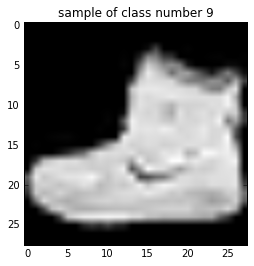

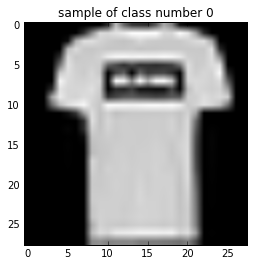

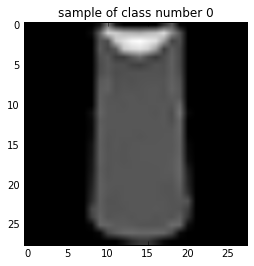

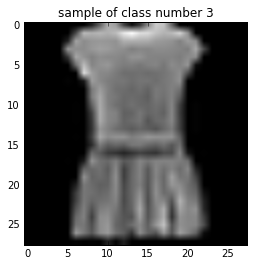

In [3]:
#lets look at some images
plt.figure()
plt.imshow(X_train[0], cmap='gray')
plt.title('sample of class number {}'.format(y_train[0]))

plt.figure()
plt.imshow(X_train[1], cmap='gray')
plt.title('sample of class number {}'.format(y_train[1]))

plt.figure()
plt.imshow(X_train[2], cmap='gray')
plt.title('sample of class number {}'.format(y_train[2]))

plt.figure()
plt.imshow(X_train[3], cmap='gray')
plt.title('sample of class number {}'.format(y_train[3]))


### Normalizing the images and converting to float

In [130]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train /= 255.0
X_test /= 255.0

### taking part of the train set for validation

In [5]:
X_train_orig = X_train
y_train_orig = y_train

print('there are {} training samples, we will take 50K for train and 10K for validation'.format(X_train.shape[0]))
X_train = X_train_orig[:50000]
y_train = y_train_orig[:50000]

X_val = X_train_orig[50000:]
y_val = y_train_orig[50000:]

there are 60000 training samples, we will take 50K for train and 10K for validation


### let's try classification with KNN


In [6]:
#Importing the NN class from sklearn  
from sklearn.neighbors import NearestNeighbors

#KNeighborsClassifier wants us to roll each image into one long vector 
X_train_rolled = X_train.reshape(-1,28*28)
X_val_rolled = X_val.reshape(-1,28*28)

#initiating a new KNN classifier 
max_K = 10
neigh = NearestNeighbors(n_neighbors=max_K)
#"training" the classifier 
neigh.fit(X_train_rolled,y_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [7]:
# getting the closest neigherst neigbors. Here we get the distance between each sample in the validtion set to
# the five closest neighbors and also the neighbors indices in the validation set 
distances, indices = neigh.kneighbors(X_val_rolled)

In [8]:
indices

array([[42052,  9801,  6756, ..., 41602, 13893,  9356],
       [41387, 30078, 27732, ..., 46595, 12616, 46418],
       [15801,  2237, 37885, ..., 49010, 23827, 12027],
       ..., 
       [45348, 22272, 43297, ...,  2717, 21782, 17233],
       [17378,  8495, 24332, ..., 11955, 11848, 13448],
       [11912, 40600, 49655, ...,  2227, 45354, 29249]])

In [9]:
#For each validation sample, we know the indices of it's 5 nn in the training set, let's see what are the labels 
#of those 5 nn
#I'm doing this with 2 loops, not the most elegant code..
y_val_pred = []
for row_ind in range(indices.shape[0]):
    cur_sample_row = []
    for col_ind in range(indices.shape[1]):
        cur_sample_row.append(y_train[indices[row_ind,col_ind]])
        
    y_val_pred.append(cur_sample_row)

In [10]:
#converting this to a numpy matrix
y_val_pred = np.array(y_val_pred)

In [11]:
#let's look at the predictions
y_val_pred

array([[9, 9, 9, ..., 9, 9, 7],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [3, 3, 3, ..., 3, 3, 3],
       [0, 0, 0, ..., 6, 0, 0],
       [5, 5, 5, ..., 5, 5, 5]], dtype=uint8)

In [12]:
#the number of neighbors is a hyper param. we'll loop over K=1,2,3,4,5
#we need to most common value in each prediction vector, for that we will use the counter class
from collections import Counter

for k in range(max_K):
    y_val_pred_for_k = y_val_pred[:,:k+1]
    
    final_prediction_vec = []
    for sample_ind in range(y_val_pred_for_k.shape[0]):
        final_prediction_vec.append(Counter(y_val_pred_for_k[sample_ind]).most_common()[0][0])
    
    final_prediction_vec = np.array(final_prediction_vec)

    #we have a final prediction for our validation set for this k, let's see what is the accuracy
    cur_acc = np.sum(final_prediction_vec==y_val)/float(len(y_val))
    print ('with k = {} our acc on the validtion is {}'.format(k+1, cur_acc))


with k = 1 our acc on the validtion is 0.8458
with k = 2 our acc on the validtion is 0.8409
with k = 3 our acc on the validtion is 0.8519
with k = 4 our acc on the validtion is 0.8506
with k = 5 our acc on the validtion is 0.8523
with k = 6 our acc on the validtion is 0.8516
with k = 7 our acc on the validtion is 0.8532
with k = 8 our acc on the validtion is 0.8518
with k = 9 our acc on the validtion is 0.8511
with k = 10 our acc on the validtion is 0.8476


### Our best k is 7, so let's try that on our test set


In [14]:
X_test_rolled = X_test.reshape(-1,28*28)
distances, indices = neigh.kneighbors(X_test_rolled)

In [15]:
y_test_pred = []
for row_ind in range(indices.shape[0]):
    cur_sample_row = []
    for col_ind in range(indices.shape[1]):
        cur_sample_row.append(y_train[indices[row_ind,col_ind]])
        
    y_test_pred.append(cur_sample_row)

#converting this to a numpy matrix
y_test_pred = np.array(y_test_pred)


In [16]:
y_test_pred_for_k = y_test_pred[:,:7+1]


final_prediction_vec = []
for sample_ind in range(y_test_pred_for_k.shape[0]):
    final_prediction_vec.append(Counter(y_test_pred_for_k[sample_ind]).most_common()[0][0])

final_prediction_vec = np.array(final_prediction_vec)

#we have a final prediction for our validation set for this k, let's see what is the accuracy
cur_acc = np.sum(final_prediction_vec==y_test)/float(len(y_test))
print ('with k = {} our acc on the test is {}'.format(k+1, cur_acc))

with k = 10 our acc on the test is 0.8474


## Let's try Linear classification 

In [19]:
#LinearSVC is one example of a linear model
from sklearn.svm import LinearSVC

#One of the hyperparameters of LR is C, how well to fit the training data or how much regularization do we want
for cur_C in [0.0001,0.0003, 0.001, 0.003, 0.01, 0.03,0.1,0.3,1.0]:
    log_reg_clf = LinearSVC(C=cur_C)
    log_reg_clf.fit(X_train_rolled,y_train) #this takes care of all the SGD and all that 
    cur_acc = log_reg_clf.score(X_val_rolled,y_val)
    print ('acc of LinearSVC with C = {} is {}'.format(cur_C, cur_acc))


acc of LinearSVC with C = 0.0001 is 0.8083
acc of LinearSVC with C = 0.0003 is 0.8271
acc of LinearSVC with C = 0.001 is 0.8417
acc of LinearSVC with C = 0.003 is 0.8484
acc of LinearSVC with C = 0.01 is 0.8528
acc of LinearSVC with C = 0.03 is 0.852
acc of LinearSVC with C = 0.1 is 0.8507
acc of LinearSVC with C = 0.3 is 0.849
acc of LinearSVC with C = 1.0 is 0.8485
acc of LinearSVC with C = 3.0 is 0.8286


In [22]:
#The best cur is 0.01 so let's try that on the test set
log_reg_clf = LinearSVC(C=0.01)
log_reg_clf.fit(X_train_rolled,y_train) #this takes care of all the SGD and all that 
test_acc = log_reg_clf.score(X_test_rolled,y_test)
print(' logistic regression with C={} reached {} acc'.format(0.01,test_acc))

 logistic regression with C=0.01 reached 0.8404 acc


## Let's try regular fully connected NN 

In [31]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

#Keras wants one-hot vector
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train,10)
Y_val = np_utils.to_categorical(y_val,10)
Y_test = np_utils.to_categorical(y_test,10)

In [41]:
## let's start with a pretty weak model, no hidden layer, just input and output with softmax
from keras.callbacks import EarlyStopping
#let's monitor the validation loss, if the validation loss does not decrease during 4 epochs we will stop training
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 


nn_model1 = Sequential()
nn_model1.add(Dense(10, input_shape = (X_train_rolled.shape[1],)))
nn_model1.add(Activation('softmax'))

nn_model1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = nn_model1.fit(X_train_rolled, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val_rolled, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 4s 87us/step - loss: 0.8722 - acc: 0.7218 - val_loss: 0.6541 - val_acc: 0.7844
Epoch 2/1000
50000/50000 [==============================] - 4s 85us/step - loss: 0.6101 - acc: 0.8035 - val_loss: 0.5793 - val_acc: 0.8081
Epoch 3/1000
50000/50000 [==============================] - 4s 87us/step - loss: 0.5556 - acc: 0.8206 - val_loss: 0.5458 - val_acc: 0.8159
Epoch 4/1000
50000/50000 [==============================] - 4s 88us/step - loss: 0.5269 - acc: 0.8273 - val_loss: 0.5230 - val_acc: 0.8206
Epoch 5/1000
50000/50000 [==============================] - 5s 92us/step - loss: 0.5078 - acc: 0.8319 - val_loss: 0.5095 - val_acc: 0.8248
Epoch 6/1000
50000/50000 [==============================] - 3s 67us/step - loss: 0.4944 - acc: 0.8361 - val_loss: 0.5000 - val_acc: 0.8306
Epoch 7/1000
50000/50000 [==============================] - 3s 70us/step - loss: 0.4843 - acc: 0.8380 - val_loss: 0.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [64]:
#we stopped training, let's calculate accuracy on the validation set
Y_pred = nn_model1.predict(X_val_rolled)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.8505


the correct class for image 1 is 9


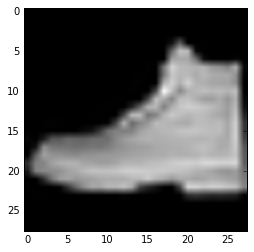

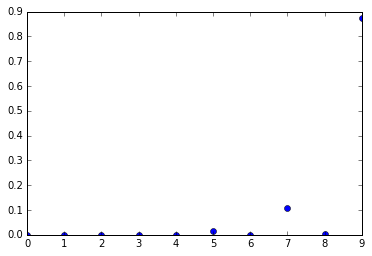

In [70]:
#prediction for image 0
plt.figure()
plt.imshow(X_val[0],cmap='gray')
plt.figure()
plt.plot(Y_pred[0],'bo')
print ( 'the correct class for image 1 is {}'.format(y_val[0]) )

the correct class for image 1 is 2


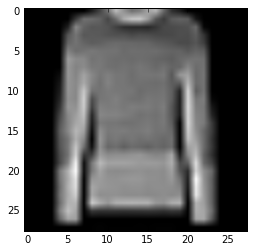

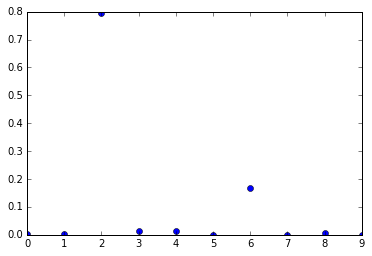

In [71]:
#prediction for image 1
plt.figure()
plt.imshow(X_val[1],cmap='gray')
plt.figure()
plt.plot(Y_pred[1],'bo')
print ( 'the correct class for image 1 is {}'.format(y_val[1]) )

In [74]:
## Let's try a more complicated model  - adding a hidden layer with 100 neurons and relu activation

#let's monitor the validation loss, if the validation loss does not decrease during 4 epochs we will stop training
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 


nn_model2 = Sequential()
nn_model2.add(Dense(100, input_shape = (X_train_rolled.shape[1],)))
nn_model2.add(Activation('relu'))

nn_model2.add(Dense(10))
nn_model2.add(Activation('softmax'))

nn_model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = nn_model2.fit(X_train_rolled, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val_rolled, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 4s 85us/step - loss: 0.7807 - acc: 0.7505 - val_loss: 0.5617 - val_acc: 0.8115
Epoch 2/1000
50000/50000 [==============================] - 4s 78us/step - loss: 0.5248 - acc: 0.8226 - val_loss: 0.5122 - val_acc: 0.8233
Epoch 3/1000
50000/50000 [==============================] - 4s 85us/step - loss: 0.4771 - acc: 0.8357 - val_loss: 0.4722 - val_acc: 0.8353
Epoch 4/1000
50000/50000 [==============================] - 5s 91us/step - loss: 0.4518 - acc: 0.8446 - val_loss: 0.4515 - val_acc: 0.8422
Epoch 5/1000
50000/50000 [==============================] - 5s 104us/step - loss: 0.4340 - acc: 0.8506 - val_loss: 0.4436 - val_acc: 0.8430
Epoch 6/1000
50000/50000 [==============================] - 5s 98us/step - loss: 0.4200 - acc: 0.8545 - val_loss: 0.4250 - val_acc: 0.8516
Epoch 7/1000
50000/50000 [==============================] - 6s 118us/step - loss: 0.4076 - acc: 0.8588 - val_loss: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [75]:
#we stopped training, let's calculate accuracy on the validation set
Y_pred = nn_model2.predict(X_val_rolled)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.881


In [76]:
## Let's try an even more complicated mode, 2 hidden layers with 512 neurons and another hidden layer with 64 neurons

#let's monitor the validation loss, if the validation loss does not decrease during 4 epochs we will stop training
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 


nn_model3 = Sequential()
nn_model3.add(Dense(512, input_shape = (X_train_rolled.shape[1],)))
nn_model3.add(Activation('relu'))
nn_model3.add(Dense(512, input_shape = (X_train_rolled.shape[1],)))
nn_model3.add(Activation('relu'))
nn_model3.add(Dense(64, input_shape = (X_train_rolled.shape[1],)))
nn_model3.add(Activation('relu'))


nn_model3.add(Dense(10))
nn_model3.add(Activation('softmax'))

nn_model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = nn_model3.fit(X_train_rolled, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val_rolled, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 16s 311us/step - loss: 0.7039 - acc: 0.7665 - val_loss: 0.5182 - val_acc: 0.8138
Epoch 2/1000
50000/50000 [==============================] - 16s 321us/step - loss: 0.4699 - acc: 0.8341 - val_loss: 0.4587 - val_acc: 0.8353
Epoch 3/1000
50000/50000 [==============================] - 16s 320us/step - loss: 0.4216 - acc: 0.8509 - val_loss: 0.4141 - val_acc: 0.8535
Epoch 4/1000
50000/50000 [==============================] - 16s 329us/step - loss: 0.3916 - acc: 0.8619 - val_loss: 0.4443 - val_acc: 0.8437
Epoch 5/1000
50000/50000 [==============================] - 17s 333us/step - loss: 0.3686 - acc: 0.8684 - val_loss: 0.4166 - val_acc: 0.8476
Epoch 6/1000
50000/50000 [==============================] - 12s 246us/step - loss: 0.3520 - acc: 0.8737 - val_loss: 0.4086 - val_acc: 0.8469
Epoch 7/1000
50000/50000 [==============================] - 16s 326us/step - loss: 0.3362 - acc: 0.8790 

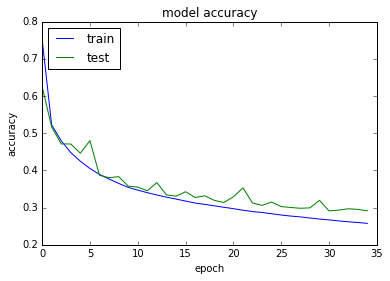

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [77]:
#we stopped training, let's calculate accuracy on the validation set
Y_pred = nn_model3.predict(X_val_rolled)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.8784


In [ ]:
#the accuracy is worse, perhpas I overfitted

### Ensemble

In [118]:
Y_pred1 = nn_model1.predict(X_val_rolled)
Y_pred2 = nn_model2.predict(X_val_rolled)
Y_pred3 = nn_model3.predict(X_val_rolled)


Y_ensemble = (Y_pred1 + Y_pred2 + Y_pred3)/3

In [119]:
correct_num = np.sum(Y_ensemble.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.8831


In [120]:
# got a slight improvment 

## Let's try regular ConvNets


In [95]:
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import  Flatten

print ('out data sahpe is {}'.format(X_train.shape))
print ('we need to add a dummy dimension as the last dimension')
X_train_orig = X_train.copy()
X_val_orig = X_val.copy()

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)

print ('now our data shape is {}'.format(X_train.shape))

out data sahpe is (50000, 28, 28, 1)
we need to add a dummy dimension as the last dimension
now our data shape is (50000, 28, 28, 1)


In [101]:
#let's start with a simple convnet - one conv layer, followed by  relu operation, and then fully connected layer
conv_model1 = Sequential()
conv_model1.add(Convolution2D(20, 3, 3,
                        border_mode='valid',
                        input_shape=(28, 28,1)))
conv_model1.add(Activation('relu'))
conv_model1.add(MaxPooling2D( pool_size = (2,2)))
conv_model1.add(Flatten())
conv_model1.add(Dense(10))
conv_model1.add(Activation('softmax'))

conv_model1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = conv_model1.fit(X_train, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 17s 336us/step - loss: 0.7538 - acc: 0.7421 - val_loss: 0.6260 - val_acc: 0.7720
Epoch 2/1000
50000/50000 [==============================] - 17s 347us/step - loss: 0.5225 - acc: 0.8148 - val_loss: 0.5169 - val_acc: 0.8150
Epoch 3/1000
50000/50000 [==============================] - 17s 347us/step - loss: 0.4795 - acc: 0.8323 - val_loss: 0.4712 - val_acc: 0.8269
Epoch 4/1000
50000/50000 [==============================] - 18s 358us/step - loss: 0.4479 - acc: 0.8426 - val_loss: 0.4710 - val_acc: 0.8355
Epoch 5/1000
50000/50000 [==============================] - 18s 358us/step - loss: 0.4247 - acc: 0.8537 - val_loss: 0.4461 - val_acc: 0.8352
Epoch 6/1000
50000/50000 [==============================] - 18s 362us/step - loss: 0.4052 - acc: 0.8604 - val_loss: 0.4801 - val_acc: 0.8250
Epoch 7/1000
50000/50000 [==============================] - 20s 396us/step - loss: 0.3893 - acc: 0.8667 

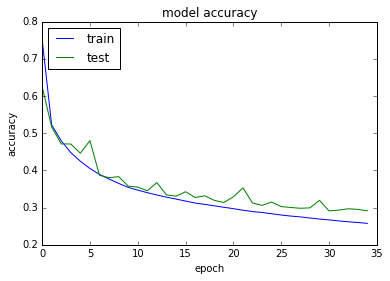

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [102]:
Y_pred = conv_model1.predict(X_val)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.8955


In [105]:
#a more complicated - one conv layer, followed by  relu operation, followed by another conv layer,
# and then fully connected layer
conv_model2 = Sequential()
conv_model2 .add(Convolution2D(20, 3, 3,
                        border_mode='valid',
                        input_shape=(28, 28,1)))
conv_model2.add(Activation('relu'))
conv_model2.add(MaxPooling2D( pool_size = (2,2)))

conv_model2 .add(Convolution2D(20, 3, 3,
                        border_mode='valid',
                        input_shape=(28, 28,1)))
conv_model2.add(Activation('relu'))
conv_model2.add(MaxPooling2D( pool_size = (2,2)))


conv_model2.add(Flatten())
conv_model2.add(Dense(10))
conv_model2.add(Activation('softmax'))

conv_model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = conv_model2.fit(X_train, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 26s 511us/step - loss: 1.0382 - acc: 0.6334 - val_loss: 0.6725 - val_acc: 0.7359
Epoch 2/1000
50000/50000 [==============================] - 23s 455us/step - loss: 0.6053 - acc: 0.7783 - val_loss: 0.5666 - val_acc: 0.7880
Epoch 3/1000
50000/50000 [==============================] - 20s 397us/step - loss: 0.5259 - acc: 0.8099 - val_loss: 0.5254 - val_acc: 0.8089
Epoch 4/1000
50000/50000 [==============================] - 20s 399us/step - loss: 0.4860 - acc: 0.8275 - val_loss: 0.4914 - val_acc: 0.8213
Epoch 5/1000
50000/50000 [==============================] - 20s 397us/step - loss: 0.4612 - acc: 0.8346 - val_loss: 0.5481 - val_acc: 0.7856
Epoch 6/1000
50000/50000 [==============================] - 20s 398us/step - loss: 0.4420 - acc: 0.8417 - val_loss: 0.4552 - val_acc: 0.8333
Epoch 7/1000
50000/50000 [==============================] - 20s 398us/step - loss: 0.4254 - acc: 0.8464 

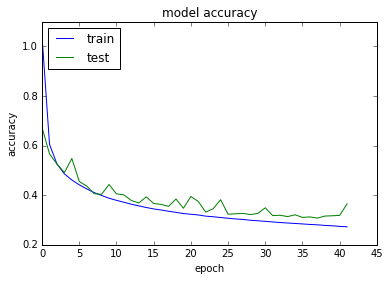

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [107]:
Y_pred = conv_model2.predict(X_val)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.8663


In [108]:
#lower acc! :( let's try to add another fc layer
conv_model3 = Sequential()
conv_model3.add(Convolution2D(20, 3, 3,
                        border_mode='valid',
                        input_shape=(28, 28,1)))
conv_model3.add(Activation('relu'))
conv_model3.add(MaxPooling2D( pool_size = (2,2)))
conv_model3.add(Flatten())
conv_model3.add(Dropout(0.5))
conv_model3.add(Dense(100))
conv_model3.add(Activation('relu'))
conv_model3.add(Dropout(0.5))
conv_model3.add(Dense(10))
conv_model3.add(Activation('softmax'))

conv_model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = conv_model3.fit(X_train, Y_train, batch_size=32, 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 25s 501us/step - loss: 1.0610 - acc: 0.6082 - val_loss: 0.6214 - val_acc: 0.7671
Epoch 2/1000
50000/50000 [==============================] - 22s 434us/step - loss: 0.7234 - acc: 0.7297 - val_loss: 0.5574 - val_acc: 0.7790
Epoch 3/1000
50000/50000 [==============================] - 25s 493us/step - loss: 0.6480 - acc: 0.7602 - val_loss: 0.4965 - val_acc: 0.8164
Epoch 4/1000
50000/50000 [==============================] - 21s 417us/step - loss: 0.5943 - acc: 0.7800 - val_loss: 0.4690 - val_acc: 0.8299
Epoch 5/1000
50000/50000 [==============================] - 21s 412us/step - loss: 0.5544 - acc: 0.7979 - val_loss: 0.4388 - val_acc: 0.8381
Epoch 6/1000
50000/50000 [==============================] - 27s 549us/step - loss: 0.5303 - acc: 0.8087 - val_loss: 0.4254 - val_acc: 0.8438
Epoch 7/1000
50000/50000 [==============================] - 21s 422us/step - loss: 0.5081 - acc: 0.8139 

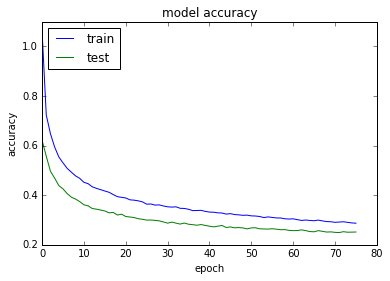

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [110]:
Y_pred = conv_model3.predict(X_val)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.9056


In [113]:
#Bamm! 90% acc! #maybe we can squeeze a bit more using data augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

conv_model3 = Sequential()
conv_model3.add(Convolution2D(20, 3, 3,
                        border_mode='valid',
                        input_shape=(28, 28,1)))
conv_model3.add(Activation('relu'))
conv_model3.add(MaxPooling2D( pool_size = (2,2)))
conv_model3.add(Flatten())
conv_model3.add(Dropout(0.5))
conv_model3.add(Dense(100))
conv_model3.add(Activation('relu'))
conv_model3.add(Dropout(0.5))
conv_model3.add(Dense(10))
conv_model3.add(Activation('softmax'))

conv_model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = conv_model3.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), 
          nb_epoch=1000,verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[early_stop])

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:32: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca...)`


Epoch 1/1000
1563/1563 [==============================] - 26s 16ms/step - loss: 1.1510 - acc: 0.5737 - val_loss: 0.6620 - val_acc: 0.7529
Epoch 2/1000
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7693 - acc: 0.7148 - val_loss: 0.5733 - val_acc: 0.7834
Epoch 3/1000
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6798 - acc: 0.7493 - val_loss: 0.5128 - val_acc: 0.8062
Epoch 4/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6158 - acc: 0.7724 - val_loss: 0.4811 - val_acc: 0.8243
Epoch 5/1000
1563/1563 [==============================] - 20s 13ms/step - loss: 0.5793 - acc: 0.7908 - val_loss: 0.4544 - val_acc: 0.8339
Epoch 6/1000
1563/1563 [==============================] - 21s 14ms/step - loss: 0.5502 - acc: 0.8014 - val_loss: 0.4330 - val_acc: 0.8434
Epoch 7/1000
1563/1563 [==============================] - 21s 14ms/step - loss: 0.5275 - acc: 0.8121 - val_loss: 0.4176 - val_acc: 0.8467
Epoch 8/1000
1563/1563 [==========

In [114]:
Y_pred = conv_model3.predict(X_val)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_val)
print ('acc is {}'.format(correct_num/float(len(y_val))))

acc is 0.9004


In [115]:
# the acc is lower, strange, never mind

## Conv3 gave the best acc on val, so let's report its performance on test 

In [131]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Y_pred = conv_model3.predict(X_test)
#how many correct predictions
correct_num = np.sum(Y_pred.argmax(axis=1)==y_test)
print ('acc is {}'.format(correct_num/float(len(y_test))))

acc is 0.897
